#### Computational Intelligence Project
#### Fruit Classification
#### Narges Sodeifi
# Step One: Reading Fruit Dataset


In [2]:
import math

from matplotlib import pyplot as plt
import numpy as np
import random
import pickle
from statistics import mean

# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4, 1)
    train_set.append((train_set_features[i].reshape(102, 1), label))

for i in range(len(test_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4, 1)
    test_set.append((test_set_features[i].reshape(102, 1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

# Needed Functions
Useful functions that we need throughout this notebook.

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def feedforward(w, a, bias, activation_func):
    z = (w @ a) + bias
    if activation_func == 'sigmoid':
        return sigmoid(z)


def cost_calculator(dataset, w1, w2, w3, b1, b2, b3, c):
    for trainData in dataset:
        a_0 = trainData[0]
        a_1 = feedforward(w1, a_0, b1, 'sigmoid')
        a_2 = feedforward(w2, a_1, b2, 'sigmoid')
        a_3 = feedforward(w3, a_2, b3, 'sigmoid')

        for j in range(4):
            c += np.power((a_3[j, 0] - trainData[1][j, 0]), 2)
    c /= len(dataset)
    total_costs.append(c)


def calculate_accuracy(dataset, w1, w2, w3, b1, b2, b3, total_num):
    correct_guesses = 0
    for trainData in dataset:
        a_0 = trainData[0]
        a_1 = feedforward(w1, a_0, b1, 'sigmoid')
        a_2 = feedforward(w2, a_1, b2, 'sigmoid')
        a_3 = feedforward(w3, a_2, b3, 'sigmoid')

        predicted_label = np.argmax(a_3, axis=0)
        real_label = np.argmax(trainData[1], axis=0)

        if predicted_label[0] == real_label[0]:
            correct_guesses += 1
    accuracy = (correct_guesses / total_num) * 100
    return accuracy


def initialize():
    w1 = np.random.standard_normal(size=(150, 102))
    b1 = np.zeros((150, 1))

    w2 = np.random.standard_normal(size=(60, 150))
    b2 = np.zeros((60, 1))

    w3 = np.random.standard_normal(size=(4, 60))
    b3 = np.zeros((4, 1))

    w = [w1, w2, w3]
    bias = [b1, b2, b3]

    return w, bias

# Step Two: Feedforward
In this step we work with 200 sample. We allocate a k * n matrix for weights between layers in the implementation.<br/>
n : number of neurons on the current layer <br>
k : number of neurons on the next layer <br>
Each row of our matrix W shows the weights of a single neuron on the following layer.

In [3]:
W_1 = np.random.normal(size=(150, 102))
W_2 = np.random.normal(size=(60, 150))
W_3 = np.random.normal(size=(4, 60))
b_1 = np.zeros((150, 1))
b_2 = np.zeros((60, 1))
b_3 = np.zeros((4, 1))

number_of_samples = 200
train_sample_200 = random.sample(train_set, number_of_samples)
print(f"Accuracy: {calculate_accuracy(train_sample_200, W_1, W_2, W_3, b_1, b_2, b_3, number_of_samples)}")

Accuracy: 28.000000000000004


Accuracy is very low in this step, because we just feedforward the network and didn't back propagate.<br>
Due to the fact that the learning process has not progressed, we anticipate an accuracy of roughly 25%.

# Step Three: Backpropagation


Setting learning rate, number of epochs and batch size

In [4]:
batch_size = 10
learning_rate = 1
number_of_epochs = 5

In [5]:
%%time
W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, number_of_samples, batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # forward propagation
            a1 = feedforward(W[0], image, b[0], 'sigmoid')
            a2 = feedforward(W[1], a1, b[1], 'sigmoid')
            a3 = feedforward(W[2], a2, b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            for j in range(grad_W3.shape[0]):
                for k in range(grad_W3.shape[1]):
                    grad_W3[j, k] += 2 * (a3[j, 0] - label[j, 0]) * derivative_sigmoid(z3[j, 0]) * a2[k, 0]

            for j in range(grad_b3.shape[0]):
                grad_b3[j, 0] += 2 * (a3[j, 0] - label[j, 0]) * derivative_sigmoid(z3[j, 0])

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            for k in range(60):
                for j in range(4):
                    grad_a2[k, 0] += 2 * (a3[j, 0] - label[j, 0]) * derivative_sigmoid(z3[j, 0]) * W[2][j, k]

            for k in range(grad_W2.shape[0]):
                for m in range(grad_W2.shape[1]):
                    grad_W2[k, m] += grad_a2[k, 0] * derivative_sigmoid(z2[k, 0]) * a1[m, 0]

            for k in range(grad_b2.shape[0]):
                grad_b2[k, 0] += grad_a2[k, 0] * derivative_sigmoid(z2[k, 0])

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            for m in range(150):
                for k in range(60):
                    grad_a1[m, 0] += grad_a2[k, 0] * derivative_sigmoid(z2[k, 0]) * W[1][k, m]

            for m in range(grad_W1.shape[0]):
                for v in range(grad_W1.shape[1]):
                    grad_W1[m, v] += grad_a1[m, 0] * derivative_sigmoid(z1[m, 0]) * image[v, 0]

            for m in range(grad_b1.shape[0]):
                grad_b1[m, 0] += grad_a1[m, 0] * derivative_sigmoid(z1[m, 0])

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))

    cost = 0
    cost_calculator(train_sample_200, W[0], W[1], W[2], b[0], b[1], b[2], cost)

CPU times: user 5min 44s, sys: 3.94 s, total: 5min 48s
Wall time: 4min 11s


Accuracy: 69.5


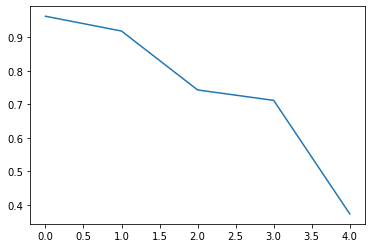

In [6]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(f"Accuracy: {calculate_accuracy(train_sample_200, W[0], W[1], W[2], b[0], b[1], b[2], number_of_samples)}")

The Cost function is decreasing. As a result, we know that our Neural Network is working properly.


# Step Four: Vectorization
To save time, we re-create the previous NN, but this time without the loops.<br>

In [7]:
%%time
batch_size = 10
learning_rate = 1
number_of_epochs = 20
W, b = initialize()
total_costs = []
for i in range(number_of_epochs):
    batches = [train_sample_200[x:x + batch_size] for x in range(0, len(train_sample_200), batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # Forward propagation
            a1 = feedforward(W[0], image, b[0], 'sigmoid')
            a2 = feedforward(W[1], a1, b[1], 'sigmoid')
            a3 = feedforward(W[2], a2, b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
            grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
            grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
            grad_b2 += grad_a2 * derivative_sigmoid(z2)

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
            grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
            grad_b1 += grad_a1 * derivative_sigmoid(z1)

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))
    cost = 0
    cost_calculator(train_sample_200, W[0], W[1], W[2], b[0], b[1], b[2], cost)

CPU times: user 3.5 s, sys: 53.5 ms, total: 3.55 s
Wall time: 1.92 s


As can be seen, the execution time is significantly reduced.

Accuracy: 100.0


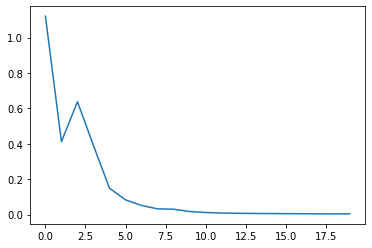

In [8]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(f"Accuracy: {calculate_accuracy(train_sample_200, W[0], W[1], W[2], b[0], b[1], b[2], len(train_sample_200))}")

Test the model ten times and average the results.

[100.0, 79.5, 100.0, 100.0, 100.0, 54.50000000000001, 100.0, 100.0, 79.5, 100.0]
Average accuracy: 91.35


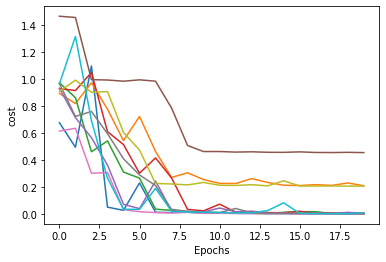

In [27]:
batch_size = 10
learning_rate = 1
number_of_epochs = 20
average_accuracy = []
for i in range(10):
    W, b = initialize()
    total_costs = []
    for i in range(number_of_epochs):
        np.random.shuffle(train_sample_200)
        batches = [train_sample_200[x:x + batch_size] for x in range(0, len(train_sample_200), batch_size)]
        for batch in batches:
            grad_W1 = np.zeros((150, 102))
            grad_b1 = np.zeros((150, 1))

            grad_W2 = np.zeros((60, 150))
            grad_b2 = np.zeros((60, 1))

            grad_W3 = np.zeros((4, 60))
            grad_b3 = np.zeros((4, 1))

            for image, label in batch:
                # Forward propagation
                a1 = feedforward(W[0], image, b[0], 'sigmoid')
                a2 = feedforward(W[1], a1, b[1], 'sigmoid')
                a3 = feedforward(W[2], a2, b[2], 'sigmoid')

                z1 = (W[0] @ image) + b[0]
                z2 = (W[1] @ a1) + b[1]
                z3 = (W[2] @ a2) + b[2]

                # Output layer
                grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
                grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

                # Hidden layer 2
                grad_a2 = np.zeros((60, 1))
                grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
                grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
                grad_b2 += grad_a2 * derivative_sigmoid(z2)

                # Hidden layer 1
                grad_a1 = np.zeros((150, 1))
                grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
                grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
                grad_b1 += grad_a1 * derivative_sigmoid(z1)

            W[0] -= (learning_rate * (grad_W1 / batch_size))
            W[1] -= (learning_rate * (grad_W2 / batch_size))
            W[2] -= (learning_rate * (grad_W3 / batch_size))

            b[0] -= (learning_rate * (grad_b1 / batch_size))
            b[1] -= (learning_rate * (grad_b2 / batch_size))
            b[2] -= (learning_rate * (grad_b3 / batch_size))
        cost = 0
        cost_calculator(train_sample_200, W[0], W[1], W[2], b[0], b[1], b[2], cost)
    epoch_size = [x for x in range(number_of_epochs)]
    plt.plot(epoch_size, total_costs)
    plt.xlabel("Epochs")
    plt.ylabel("cost")
    average_accuracy.append(calculate_accuracy(train_sample_200, W[0], W[1], W[2], b[0], b[1], b[2], number_of_samples))
print(average_accuracy)
print(f"Average accuracy: {mean(average_accuracy)}")

# Step Five: Testing the Model
Finally, we take the complete dataset as input and iterate through all of the photographs to determine the correctness of our train and test sets with no regard for time.


In [15]:
%%time
batch_size = 10
learning_rate = 1
number_of_epochs = 10
total_costs = []
W, b = initialize()
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 102))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((4, 60))
        grad_b3 = np.zeros((4, 1))

        for image, label in batch:
            # Forward propagation
            a1 = feedforward(W[0], image, b[0], 'sigmoid')
            a2 = feedforward(W[1], a1, b[1], 'sigmoid')
            a3 = feedforward(W[2], a2, b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
            grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
            grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
            grad_b2 += grad_a2 * derivative_sigmoid(z2)

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
            grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
            grad_b1 += grad_a1 * derivative_sigmoid(z1)

        W[0] -= (learning_rate * (grad_W1 / batch_size))
        W[1] -= (learning_rate * (grad_W2 / batch_size))
        W[2] -= (learning_rate * (grad_W3 / batch_size))

        b[0] -= (learning_rate * (grad_b1 / batch_size))
        b[1] -= (learning_rate * (grad_b2 / batch_size))
        b[2] -= (learning_rate * (grad_b3 / batch_size))
    cost = 0
    cost_calculator(train_set, W[0], W[1], W[2], b[0], b[1], b[2], cost)

CPU times: user 18 s, sys: 366 ms, total: 18.3 s
Wall time: 16.7 s


Accuracy of our model for train set is: 100.0
Accuracy of our model for test set is: 100.0


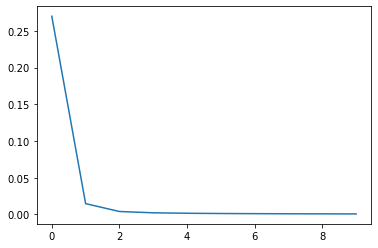

In [16]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(
    f"Accuracy of our model for train set is: {calculate_accuracy(train_set, W[0], W[1], W[2], b[0], b[1], b[2], len(train_set))}")
print(
    f"Accuracy of our model for test set is: {calculate_accuracy(test_set, W[0], W[1], W[2], b[0], b[1], b[2], len(test_set))}")

Test the model ten times and average the results.

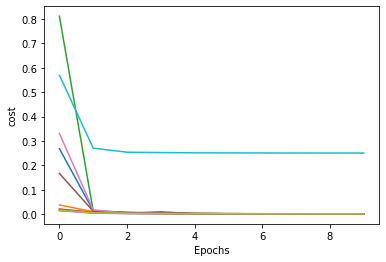

In [26]:
batch_size = 10
learning_rate = 1
number_of_epochs = 10
average_accuracy = []
for i in range(10):
    W, b = initialize()
    total_costs = []
    for i in range(number_of_epochs):
        np.random.shuffle(train_set)
        batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
        for batch in batches:
            grad_W1 = np.zeros((150, 102))
            grad_b1 = np.zeros((150, 1))

            grad_W2 = np.zeros((60, 150))
            grad_b2 = np.zeros((60, 1))

            grad_W3 = np.zeros((4, 60))
            grad_b3 = np.zeros((4, 1))

            for image, label in batch:
                # Forward propagation
                a1 = feedforward(W[0], image, b[0], 'sigmoid')
                a2 = feedforward(W[1], a1, b[1], 'sigmoid')
                a3 = feedforward(W[2], a2, b[2], 'sigmoid')

                z1 = (W[0] @ image) + b[0]
                z2 = (W[1] @ a1) + b[1]
                z3 = (W[2] @ a2) + b[2]

                # Output layer
                grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
                grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

                # Hidden layer 2
                grad_a2 = np.zeros((60, 1))
                grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
                grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
                grad_b2 += grad_a2 * derivative_sigmoid(z2)

                # Hidden layer 1
                grad_a1 = np.zeros((150, 1))
                grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
                grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
                grad_b1 += grad_a1 * derivative_sigmoid(z1)

            W[0] -= (learning_rate * (grad_W1 / batch_size))
            W[1] -= (learning_rate * (grad_W2 / batch_size))
            W[2] -= (learning_rate * (grad_W3 / batch_size))

            b[0] -= (learning_rate * (grad_b1 / batch_size))
            b[1] -= (learning_rate * (grad_b2 / batch_size))
            b[2] -= (learning_rate * (grad_b3 / batch_size))
        cost = 0
        cost_calculator(train_set, W[0], W[1], W[2], b[0], b[1], b[2], cost)
    epoch_size = [x for x in range(number_of_epochs)]
    plt.plot(epoch_size, total_costs)
    plt.xlabel("Epochs")
    plt.ylabel("cost")
    average_accuracy.append(calculate_accuracy(train_set, W[0], W[1], W[2], b[0], b[1], b[2], len(train_set)))

In [13]:
print(f"Average accuracy: {mean(average_accuracy)}")

Average accuracy: 100.0


# Extra points
## Part1
To avoid a local minimum, test the model with different Hyper-parameters.

### 1.Learning rate<br>
<b>Hyperparameters:<br></b>
batch_size = 10<br>
learning_rate = 0.5<br>
number_of_epochs = 10<br>
result:<br>
Accuracy of our model for train set is: 100.0<br>
Accuracy of our model for test set is: 99.69<br>
As the learning rate decreases, the accuracy of our test set decreases.

<b>Hyperparameters:<br></b>
batch_size = 10<br>
learning_rate = 2<br>
number_of_epochs = 10<br>
result:<br>
Accuracy of our model for train set is: 25.07<br>
Accuracy of our model for test set is: 24.77<br>
As we can see from the definition of learning rate, The lower the value, the more slowly we move down the hill. Increasing this figure, as we can see, is not a smart idea.

<b>Hyperparameters:<br></b>
batch_size = 10<br>
learning_rate = 1<br>
number_of_epochs = 10<br>
result:<br>
Accuracy of our model for train set is: 100.0<br>
Accuracy of our model for test set is: 100.0<br>
When the learning rate is one, the best results are obtained.

### 2.Number of epochs<br>
Let's try a few different values for the number of epochs now.<br>
As we can see, as the number of epochs increases, our graph becomes smoother and better fitted. However, increasing this number too high may create overfitting and require too much time, thus our best options are between 15-20.
<table><tr>
    <td>
        <figure>
            <img src="images/NOF-15.jpg" width="200" height="100"><br>
            <figcaption>number of epochs = 15</figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images/NOF-20.jpg" width="200" height="100"><br>
            <figcaption>number of epochs = 20</figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images/NOF-30.jpg" width="200" height="100"><br>
            <figcaption>number of epochs = 30</figcaption>
        </figure>
    </td>
</tr></table>

### 3.Batch size
As can be seen from the graphs, a value between 10-15 fits the best.<br>
<table><tr>
    <td>
        <figure>
            <img src="images/Bsize-5.jpg" width="200" height="100"><br>
            <figcaption>batch size = 5</figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images/Bsize-15.jpg" width="200" height="100"><br>
            <figcaption>batch size = 15</figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images/Bsize-20.jpg" width="200" height="100"><br>
            <figcaption>batch size = 20</figcaption>
        </figure>
    </td>
</tr></table>

## Part2
We'll utilize adaptive gradient, or AdaGrad, to enhance the local minimum problem and see how it works on our dataset.<br>
<img src="images/equation.png" width="200" height="100"><br>

<ipython-input-3-94eb9f358698>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Average accuracy: 24.99490316004077


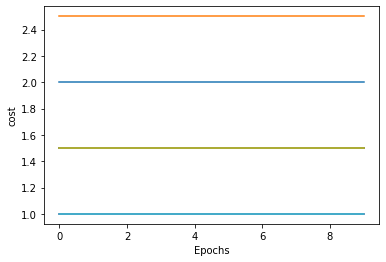

In [10]:
batch_size = 10
learning_rate = 4
number_of_epochs = 10
average_accuracy = []
for i in range(10):
    total_costs = []
    W, b = initialize()
    vt_w1 = 0
    vt_w2 = 0
    vt_w3 = 0
    vt_b1 = 0
    vt_b2 = 0
    vt_b3 = 0
    e = math.pow(10 , -7)
    for i in range(number_of_epochs):
        np.random.shuffle(train_set)
        batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
        for batch in batches:
            grad_W1 = np.zeros((150, 102))
            grad_b1 = np.zeros((150, 1))

            grad_W2 = np.zeros((60, 150))
            grad_b2 = np.zeros((60, 1))

            grad_W3 = np.zeros((4, 60))
            grad_b3 = np.zeros((4, 1))

            for image, label in batch:
                # Forward propagation
                a1 = feedforward(W[0], image, b[0], 'sigmoid')
                a2 = feedforward(W[1], a1, b[1], 'sigmoid')
                a3 = feedforward(W[2], a2, b[2], 'sigmoid')

                z1 = (W[0] @ image) + b[0]
                z2 = (W[1] @ a1) + b[1]
                z3 = (W[2] @ a2) + b[2]

                # Output layer
                grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
                grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

                # Hidden layer 2
                grad_a2 = np.zeros((60, 1))
                grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
                grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
                grad_b2 += grad_a2 * derivative_sigmoid(z2)

                # Hidden layer 1
                grad_a1 = np.zeros((150, 1))
                grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
                grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
                grad_b1 += grad_a1 * derivative_sigmoid(z1)

            W[0] -= ((learning_rate/(np.sqrt(vt_w1+e))) * (grad_W1 / batch_size))
            W[1] -= ((learning_rate/(np.sqrt(vt_w2+e))) * (grad_W2 / batch_size))
            W[2] -= ((learning_rate/(np.sqrt(vt_w3+e))) * (grad_W3 / batch_size))

            vt_w1 = vt_w1 + np.power((grad_W1 / batch_size), 2)
            vt_w2 = vt_w2 + np.power((grad_W2 / batch_size), 2)
            vt_w3 = vt_w3 + np.power((grad_W3 / batch_size), 2)

            b[0] -= ((learning_rate/(np.sqrt(vt_b1+e))) * (grad_b1 / batch_size))
            b[1] -= ((learning_rate/(np.sqrt(vt_b2+e))) * (grad_b2 / batch_size))
            b[2] -= ((learning_rate/(np.sqrt(vt_b3+e))) * (grad_b3 / batch_size))

            vt_b1 = vt_b1 + np.power((grad_b1 / batch_size), 2)
            vt_b2 = vt_b2 + np.power((grad_b2 / batch_size), 2)
            vt_b3 = vt_b3 + np.power((grad_b3 / batch_size), 2)

        cost = 0
        cost_calculator(train_set, W[0], W[1], W[2], b[0], b[1], b[2], cost)
    epoch_size = [x for x in range(number_of_epochs)]
    plt.plot(epoch_size, total_costs)
    plt.xlabel("Epochs")
    plt.ylabel("cost")
    average_accuracy.append(calculate_accuracy(train_set, W[0], W[1], W[2], b[0], b[1], b[2], len(train_set)))
print(f"Average accuracy: {mean(average_accuracy)}")

I tried AdaGrad with various learning rates, and it didn't seem to function well on our data, so let's try gradient boosting with momentum.

Average accuracy: 100.0


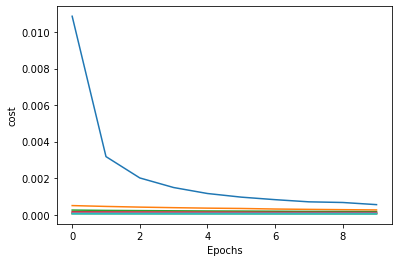

In [15]:
batch_size = 10
learning_rate = 1
number_of_epochs = 10
average_accuracy = []
momentum_factor = 0.1
W, b = initialize()
for i in range(10):
    total_costs = []
    mt_w1 = 0
    mt_w2 = 0
    mt_w3 = 0
    mt_b1 = 0
    mt_b2 = 0
    mt_b3 = 0
    for i in range(number_of_epochs):
        np.random.shuffle(train_set)
        batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
        for batch in batches:
            grad_W1 = np.zeros((150, 102))
            grad_b1 = np.zeros((150, 1))

            grad_W2 = np.zeros((60, 150))
            grad_b2 = np.zeros((60, 1))

            grad_W3 = np.zeros((4, 60))
            grad_b3 = np.zeros((4, 1))

            for image, label in batch:
                # Forward propagation
                a1 = feedforward(W[0], image, b[0], 'sigmoid')
                a2 = feedforward(W[1], a1, b[1], 'sigmoid')
                a3 = feedforward(W[2], a2, b[2], 'sigmoid')

                z1 = (W[0] @ image) + b[0]
                z2 = (W[1] @ a1) + b[1]
                z3 = (W[2] @ a2) + b[2]

                # Output layer
                grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
                grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

                # Hidden layer 2
                grad_a2 = np.zeros((60, 1))
                grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
                grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
                grad_b2 += grad_a2 * derivative_sigmoid(z2)

                # Hidden layer 1
                grad_a1 = np.zeros((150, 1))
                grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
                grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
                grad_b1 += grad_a1 * derivative_sigmoid(z1)

            W[0] -= (learning_rate * (grad_W1 / batch_size) + mt_w1)
            W[1] -= (learning_rate * (grad_W2 / batch_size) + mt_w2)
            W[2] -= (learning_rate * (grad_W3 / batch_size) + mt_w3)

            mt_w1 = (learning_rate * (grad_W1 / batch_size) + mt_w1) * momentum_factor
            mt_w2 = (learning_rate * (grad_W2 / batch_size) + mt_w2) * momentum_factor
            mt_w3 = (learning_rate * (grad_W3 / batch_size) + mt_w3) * momentum_factor

            b[0] -= (learning_rate * (grad_b1 / batch_size) + mt_b1)
            b[1] -= (learning_rate * (grad_b2 / batch_size) + mt_b2)
            b[2] -= (learning_rate * (grad_b3 / batch_size) + mt_b3)

            mt_b1 = (learning_rate * (grad_b1 / batch_size) + mt_b1) * momentum_factor
            mt_b2 = (learning_rate * (grad_b2 / batch_size) + mt_b2) * momentum_factor
            mt_b3 = (learning_rate * (grad_b3 / batch_size) + mt_b3) * momentum_factor

        cost = 0
        cost_calculator(train_set, W[0], W[1], W[2], b[0], b[1], b[2], cost)
    epoch_size = [x for x in range(number_of_epochs)]
    plt.plot(epoch_size, total_costs)
    plt.xlabel("Epochs")
    plt.ylabel("cost")
    average_accuracy.append(calculate_accuracy(train_set, W[0], W[1], W[2], b[0], b[1], b[2], len(train_set)))
print(f"Average accuracy: {mean(average_accuracy)}")

As we can see from the graph we avoided local minimums.<br>
learning rates : 0.5 , 1 (The best result apear on 1)

## Part3
We'll experiment with one more fruit (carrot) categories to see how well our model performs.

In [48]:
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0, 0, 0, 0, 0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(5, 1)
    train_set.append((train_set_features[i].reshape(103, 1), label))

for i in range(len(test_set_features)):
    label = np.array([0, 0, 0, 0, 0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(5, 1)
    test_set.append((test_set_features[i].reshape(103, 1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

Then we are going to test our model with new data

In [78]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def derivative_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))


def feedforward(w, a, bias, activation_func):
    z = (w @ a) + bias
    if activation_func == 'sigmoid':
        return sigmoid(z)


def cost_calculator(dataset, w1, w2, w3, b1, b2, b3, c):
    for trainData in dataset:
        a_0 = trainData[0]
        a_1 = feedforward(w1, a_0, b1, 'sigmoid')
        a_2 = feedforward(w2, a_1, b2, 'sigmoid')
        a_3 = feedforward(w3, a_2, b3, 'sigmoid')

        for j in range(5):
            c += np.power((a_3[j, 0] - trainData[1][j, 0]), 2)
    c /= len(dataset)
    total_costs.append(c)


def calculate_accuracy(dataset, w1, w2, w3, b1, b2, b3, total_num):
    correct_guesses = 0
    for trainData in dataset:
        a_0 = trainData[0]
        a_1 = feedforward(w1, a_0, b1, 'sigmoid')
        a_2 = feedforward(w2, a_1, b2, 'sigmoid')
        a_3 = feedforward(w3, a_2, b3, 'sigmoid')

        predicted_label = np.argmax(a_3, axis=0)
        real_label = np.argmax(trainData[1], axis=0)

        if predicted_label[0] == real_label[0]:
            correct_guesses += 1
    accuracy = (correct_guesses / total_num) * 100
    return accuracy


def initialize():
    w1 = np.random.standard_normal(size=(150, 103))
    b1 = np.zeros((150, 1))

    w2 = np.random.standard_normal(size=(60, 150))
    b2 = np.zeros((60, 1))

    w3 = np.random.standard_normal(size=(5, 60))
    b3 = np.zeros((5, 1))

    w = [w1, w2, w3]
    bias = [b1, b2, b3]

    return w, bias


batch_size = 10
learning_rate = 1
number_of_epochs = 25
total_costs = []
momentum_factor = 0.1
mt_w1 = 0
mt_w2 = 0
mt_w3 = 0
mt_b1 = 0
mt_b2 = 0
mt_b3 = 0

W, b = initialize()
for i in range(number_of_epochs):
    batches = [train_set[x:x + batch_size] for x in range(0, len(train_set), batch_size)]
    for batch in batches:
        grad_W1 = np.zeros((150, 103))
        grad_b1 = np.zeros((150, 1))

        grad_W2 = np.zeros((60, 150))
        grad_b2 = np.zeros((60, 1))

        grad_W3 = np.zeros((5, 60))
        grad_b3 = np.zeros((5, 1))

        for image, label in batch:
            # Forward propagation
            a1 = feedforward(W[0], image, b[0], 'sigmoid')
            a2 = feedforward(W[1], a1, b[1], 'sigmoid')
            a3 = feedforward(W[2], a2, b[2], 'sigmoid')

            z1 = (W[0] @ image) + b[0]
            z2 = (W[1] @ a1) + b[1]
            z3 = (W[2] @ a2) + b[2]

            # Output layer
            grad_W3 += (2 * (a3 - label) * derivative_sigmoid(z3)) @ np.transpose(a2)
            grad_b3 += 2 * (a3 - label) * derivative_sigmoid(z3)

            # Hidden layer 2
            grad_a2 = np.zeros((60, 1))
            grad_a2 += np.transpose(W[2]) @ (2 * (a3 - label) * derivative_sigmoid(z3))
            grad_W2 += (derivative_sigmoid(z2) * grad_a2) @ np.transpose(a1)
            grad_b2 += grad_a2 * derivative_sigmoid(z2)

            # Hidden layer 1
            grad_a1 = np.zeros((150, 1))
            grad_a1 += np.transpose(W[1]) @ (grad_a2 * derivative_sigmoid(z2))
            grad_W1 += (grad_a1 * derivative_sigmoid(z1)) @ np.transpose(image)
            grad_b1 += grad_a1 * derivative_sigmoid(z1)

        W[0] -= (learning_rate * (grad_W1 / batch_size) + mt_w1)
        W[1] -= (learning_rate * (grad_W2 / batch_size) + mt_w2)
        W[2] -= (learning_rate * (grad_W3 / batch_size) + mt_w3)

        mt_w1 = (learning_rate * (grad_W1 / batch_size) + mt_w1) * momentum_factor
        mt_w2 = (learning_rate * (grad_W2 / batch_size) + mt_w2) * momentum_factor
        mt_w3 = (learning_rate * (grad_W3 / batch_size) + mt_w3) * momentum_factor

        b[0] -= (learning_rate * (grad_b1 / batch_size) + mt_b1)
        b[1] -= (learning_rate * (grad_b2 / batch_size) + mt_b2)
        b[2] -= (learning_rate * (grad_b3 / batch_size) + mt_b3)

        mt_b1 = (learning_rate * (grad_b1 / batch_size) + mt_b1) * momentum_factor
        mt_b2 = (learning_rate * (grad_b2 / batch_size) + mt_b2) * momentum_factor
        mt_b3 = (learning_rate * (grad_b3 / batch_size) + mt_b3) * momentum_factor

    cost = 0
    cost_calculator(train_set, W[0], W[1], W[2], b[0], b[1], b[2], cost)


Accuracy of our model for train set is: 90.30538051381484
Accuracy of our model for test set is: 85.95505617977528


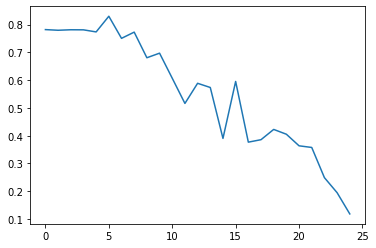

In [77]:
epoch_size = [x for x in range(number_of_epochs)]
plt.plot(epoch_size, total_costs)
print(
    f"Accuracy of our model for train set is: {calculate_accuracy(train_set, W[0], W[1], W[2], b[0], b[1], b[2], len(train_set))}")
print(
    f"Accuracy of our model for test set is: {calculate_accuracy(test_set, W[0], W[1], W[2], b[0], b[1], b[2], len(test_set))}")